### Modelo Final Segmentación/Volumen -> MoE4

In [2]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import unets_repo
from keras import backend as K
import cv2

In [4]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data"

batch_size = 1
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
vspe = n_val_img//batch_size

def load_data(ids,suj_path,mask_path):
  suj_files = os.listdir(suj_path)
  mask_files = os.listdir(mask_path)
  X = []
  Y = []

  for i in ids:
    x = np.load(os.path.join(suj_path,suj_files[i]))
    y = np.load(os.path.join(mask_path,mask_files[i]))

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)
def batch_generator(suj_path, mask_path,batch_size):
    suj_files = os.listdir(suj_path)
    indices = np.arange(len(suj_files))
    indices = np.random.permutation(indices)
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch) == batch_size:
                    yield load_data(batch,suj_path,mask_path)
                    batch = []

train_gen_ds = batch_generator(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"),batch_size)
val_gen_ds = batch_generator(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"),batch_size)

#### Métricas

> Se agrego el casteo a Double para el cálculo del Dice manual

In [5]:
def Dice(targets, inputs):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + K.epsilon()) / (K.sum(targets) + K.sum(inputs) + K.epsilon())

def Jaccard(targets, inputs):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    
    intersection = K.sum(K.abs(inputs * targets))
    union = K.sum(inputs) + K.sum(targets) - intersection
    
    return (intersection + K.epsilon())/(union + K.epsilon())

#### Modelos elegidos
    > Attention Unet w/SeLu
    > Unet 3+ w/ReLu
    > Small Unet w/ReLu (32 filters + ConvTranspose)
    > Classic Unet w/SeLu (64 filters + Upsampling/Conv2d)

Tomando las 9 redes mejores estudiadas: <br>
> Se buscó por cada red el mejor threshold tal que mejore su Dice <br>
 Se estudió cuales redes clasifican mejor el dataset de validación para máscaras con y sin próstata <br>
 Se seleccionó las 4 mejores considerando también una diversificación en sus caracteristicas (attention, unet3+, small, upsampling) <br>

Luego se buscó el mejor threshold para el MoE <br>

En conclusión se construyó un Mixture of Experts con threshold estático (so far) de 4 modelos.

In [ ]:
#coeff =   [95, 123, 52, 131, 64, 76, 66, 89, 112] #cuantas fueron el mejor dice de las imagenes con prostata
#coeff_n = [559, 512, 554, 553, 556, 532, 537, 544, 545] # +1 si dijieron q es full background y era.
#indices = [0.95, 0.45, 0.7, 0.65, 0.85, 0.95, 0.95, 0.95, 0.75]

In [6]:
attunetselu = unets_repo.AttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
attunetselu.load_weights("modelsh5/0.8160_attunet_selu_lecun_aug_dicebce.h5")
unet3 = unets_repo.unet3plus(input_size=(256,256,1))
unet3.load_weights("modelsh5/0.5662_unet3plus_relu_aug_dicebce.h5")
sunet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=32)
sunet.load_weights("modelsh5/0.7947_unet_small_relu_he_aug.h5")
classicunet = unets_repo.classicUNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
classicunet.load_weights("modelsh5/0.8233_classicunet_selu_lecun_aug_dicebce.h5")

In [ ]:
#attunetselu.save("modelsh5/attunet_final.h5")
#unet3.save("modelsh5/unet3_final.h5")
#sunet.save("modelsh5/sunet_final.h5")
#classicunet.save("modelsh5/classicunet_final.h5")

In [7]:
netnames = ["AttUnet w/s","Unet3+","sUnet","ClassicUnet"]
nets = [attunetselu,unet3,sunet,classicunet]
thresholds = [0.95,0.45,0.65,0.95] # th talque hard dice score es máx en set de validación
coeff = [169, 201, 228, 161] # cantidad de imágenes CON prostata donde obtuvieron mejor hard dice score
moe_th = 0.4 # th talque hard dice score es máx en set de validación

In [8]:
dice = 0
for _ in range(n_val_img):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = np.zeros(shape=(1,256,256,256))
    for i,net in enumerate(nets):
        prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff) #se pondera según su performance en imágenes con próstata.
    predicted_img_th = (prediction[0,:,:,0] > moe_th)*1
    dice += Dice(ground_truth,predicted_img_th).numpy()
print(dice/n_val_img)

0.8603819215897125


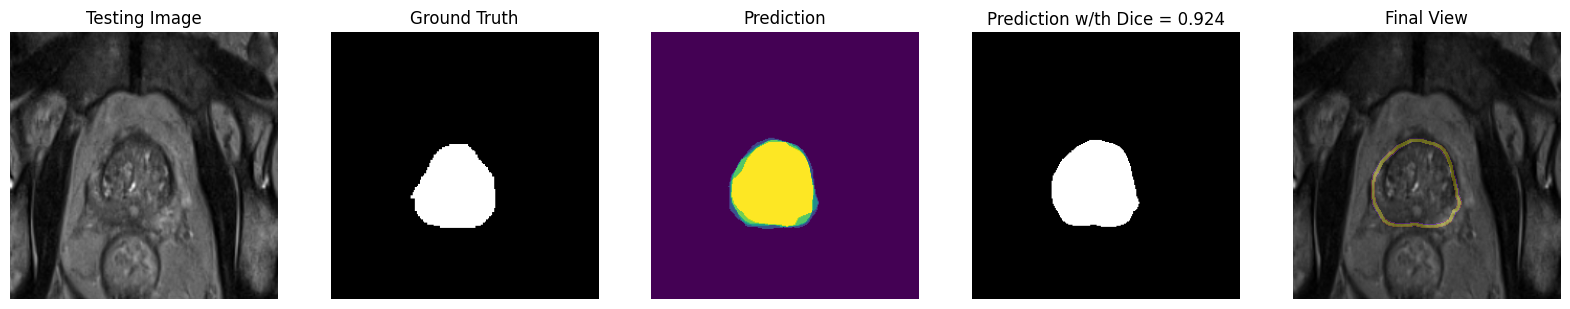

In [597]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img = test_image_batch[0]
ground_truth = test_mask_batch[0]
test_img_norm = test_img[:,:]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = np.zeros(shape=(1,256,256,256))
for i,net in enumerate(nets):
    prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff)
predicted_img_th = (prediction[0,:,:,0] > moe_th)*1
dice = Dice(ground_truth,predicted_img_th).numpy()

contours, _ = cv2.findContours(predicted_img_th.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bg = np.zeros(shape=(256,256))
bordes = cv2.drawContours(bg, contours, -1, (255, 255, 255), 2)


plt.figure(figsize=(20, 10))
plt.subplot(251)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.axis("off")
plt.subplot(252)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='gray')
plt.axis("off")
plt.subplot(253)
plt.title('Prediction')
plt.imshow(prediction[0,:,:,0])
plt.axis("off")
plt.subplot(254)
plt.title(f'Prediction w/th Dice = {round(dice,3)}')
plt.imshow(predicted_img_th, cmap='gray')
plt.axis("off")
plt.subplot(255)
plt.title(f'Final View')
plt.imshow(test_img,cmap="gray")
plt.imshow(bordes,alpha=0.3,cmap="gnuplot")
plt.axis("off")
plt.show()